# Example of Kalman Filter decoders

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing is different for the Kalman, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=0&preview=example_data_s1.pickle). It was recorded by Raeed Chowdhury from Lee Miller's lab at Northwestern.

The data that we load is in the format described below. We have another example script, "neural_preprocessing.py" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [2]:
folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 

#with open(folder+'example_data_s1.pickle','rb') as f:
with open(folder+'example_data_m1.pickle','rb') as f:
#     neural_data,vels_binned=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,vels_binned=pickle.load(f)
    
# #If you would prefer to load the '.h5' example file rather than the '.pickle' example file.
# data=dd.io.load(folder+'example_data_s1.h5')
# neural_data=data['neural_data']
# vels_binned=data['vels_binned']

In [3]:
neural_data.shape

(25299, 164)

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [4]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### 3B. Format Covariates

#### Format Input

In [5]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data

In [6]:
X_kf

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Format Output

In [7]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine position
pos_binned=np.zeros(vels_binned.shape) #Initialize 
pos_binned[0,:]=0 #Assume starting position is at [0,0]
#Loop through time bins and determine positions based on the velocities
for i in range(pos_binned.shape[0]-1): 
    pos_binned[i+1,0]=pos_binned[i,0]+vels_binned[i,0]*.05 #Note that .05 is the length of the time bin
    pos_binned[i+1,1]=pos_binned[i,1]+vels_binned[i,1]*.05

#We will now determine acceleration    
temp=np.diff(vels_binned,axis=0) #The acceleration is the difference in velocities across time bins 
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

#The final output covariates include position, velocity, and acceleration
y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

In [8]:
print(y_kf.shape)
print(X_kf.shape)
print(pos_binned.shape)

(25299, 6)
(25299, 164)
(25299, 2)


### 3C. Take lag into account

In [9]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [10]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

### Split Data: For KF

In [11]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

/tmp/ipykernel_4713/735105408.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
/tmp/ipykernel_4713/735105408.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

In [12]:
X_kf_valid.T.shape

(164, 3793)

### 3E. Preprocessing: Normalization and zero-centering
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

In [13]:
#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

In [14]:
print(y_kf_train.shape)
print(y_kf_valid.shape)
print(y_kf_test.shape)

(17707, 6)
(3793, 6)
(3793, 6)


## 4. Run Decoder
Note that in this example, we are evaluating the model fit on the validation set

### Kalman Filter

In [17]:
import time

#Declare model
model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

start = time.time()
#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)
end = time.time()
print(end - start)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

1.9676628112792969
R2: [0.70283181 0.69179512]
rho2: [0.7297484  0.74582555]


In [18]:
y_valid_predicted_kf[1,:]

array([ 4.97861965, -6.39276792, -5.37991873, -0.31415295, -0.33907169,
        0.84742554])

In [172]:
X_kf_valid.T[:,1]

array([-0.753236  , -0.32789325, -0.29694172,  0.82771067, -0.47923531,
       -0.11163928, -0.13808154, -0.47612231, -0.32990689,  0.20011297,
       -0.34729321,  1.61095119,  4.27443405, -1.06167822, -0.32738875,
       -0.63660876, -0.42864185,  1.15508876,  1.74032065, -0.65315675,
        0.19322304,  0.18635939, -0.54505873, -0.27424835, -0.80076238,
        0.78787044,  0.29264459, -0.57892214,  0.32729586, -0.28677135,
       -0.23266334, -0.3930669 , -0.49349641,  0.35176339, -0.30863601,
        0.33561151,  0.29442591, -0.81407605, -0.63850905, -0.29441206,
        0.66061806, -0.37600751, -0.44213227, -0.46639024, -0.2957264 ,
       -0.34529539,  1.71676257, -0.47214777, -0.30697588, -0.24614796,
       -0.52770824, -0.64102627, -0.25145597,  0.08977003, -0.92060313,
       -0.65523648,  1.16275718, -0.78878065, -0.07096832, -0.15923469,
       -0.165219  , -0.78282864,  0.7086142 , -0.54536443, -0.36598697,
       -0.7778396 , -0.59700715, -0.84061752,  0.59670325, -1.01

In [163]:
y_valid_predicted_kf.T[:,1]

array([ 4.97861965, -6.39276792, -5.37991873, -0.31415295, -0.33907169,
        0.84742554])

In [82]:
A,W,H,Q = model_kf.model

In [147]:
matrices = model_kf.model

In [148]:
print(A.shape)
print(W.shape)
print(H.shape)
print(Q.shape)

num_states = np.matrix(y_kf_valid.T).shape[0]
print(num_states)
num_neurons = np.matrix(X_kf_valid.T).shape[0]
print(num_neurons)

(6, 6)
(6, 6)
(164, 6)
(164, 164)
6
164


In [151]:
print(A)

[[ 9.99999991e-01 -5.53436991e-09  5.00000027e-02 -2.79810025e-09
  -1.35241238e-10 -1.29276834e-08]
 [-3.88396588e-09  9.99999998e-01  1.11290989e-09  4.99999988e-02
  -5.62050684e-11 -5.37263120e-09]
 [ 7.91560022e-09  4.68751798e-09  9.99999998e-01  2.36994385e-09
   1.00000000e+00  1.09495303e-08]
 [-1.13499874e-08 -6.72131868e-09  3.25222034e-09  9.99999997e-01
  -1.64246339e-10  9.99999984e-01]
 [-1.57959918e-02 -1.94564152e-02 -6.58598404e-02 -5.76615379e-03
   7.96963032e-01 -3.04185259e-02]
 [ 1.45967533e-02 -2.70009081e-02 -5.77255910e-03 -9.09666033e-02
  -3.12457262e-02  6.93125512e-01]]


In [176]:
#printing raw values into a file for tests                                                                                                                          
counter = 0
with open('A_array.h', 'w') as f:
  f.write("float A[] = {")
  for item in np.nditer(np.ravel(A)):
    if(counter < A.shape[0]*A.shape[1]):
      f.write(str(item))
      if(counter < A.shape[0]*A.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('W_array.h', 'w') as f:
  f.write("float W[] = {")
  for item in np.nditer(np.ravel(W)):
    if(counter < W.shape[0]*W.shape[1]):
      f.write(str(item))
      if(counter < W.shape[0]*W.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('H_array.h', 'w') as f:
  f.write("float H[] = {")
  for item in np.nditer(np.ravel(H)):
    if(counter < H.shape[0]*H.shape[1]):
      f.write(str(item))
      if(counter < H.shape[0]*H.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('Q_array.h', 'w') as f:
  f.write("float Q[] = {")
  for item in np.nditer(np.ravel(Q)):
    if(counter < Q.shape[0]*Q.shape[1]):
      f.write(str(item))
      if(counter < Q.shape[0]*Q.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close()
    
counter = 0
with open('initial_state_array.h', 'w') as f:
  f.write("float initial[] = {")
  for item in np.nditer(np.ravel(y_kf_valid.T[:,0])):
    if(counter < y_kf_valid.T[:,0].shape[0]):
      f.write(str(item))
      if(counter < y_kf_valid.T[:,0].shape[0] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 
    
counter = 0
with open('measurements_array.h', 'w') as f:
  f.write("float measurements[] = {")
  for item in np.nditer(np.ravel(X_kf_valid)):
    if(counter < X_kf_valid.T.shape[0]*X_kf_valid.T.shape[1]):
      f.write(str(item))
      if(counter < X_kf_valid.T.shape[0]*X_kf_valid.T.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 
    
    
counter = 0
with open('prediction_array.h', 'w') as f:
  f.write("float prediction[] = {")
  for item in np.nditer(np.ravel(y_valid_predicted_kf)):
    if(counter < y_valid_predicted_kf.T.shape[0]*y_valid_predicted_kf.T.shape[1]):
      f.write(str(item))
      if(counter < y_valid_predicted_kf.T.shape[0]*y_valid_predicted_kf.T.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 
    
counter = 0
with open('real_array.h', 'w') as f:
  f.write("float real_out[] = {")
  for item in np.nditer(np.ravel(y_kf_valid)):
    if(counter < y_kf_valid.T.shape[0]*y_kf_valid.T.shape[1]):
      f.write(str(item))
      if(counter < y_kf_valid.T.shape[0]*y_kf_valid.T.shape[1] - 1):
        f.write(', ')
      counter = counter+1

  f.write("};")
  f.close() 


## 5. Make Plots

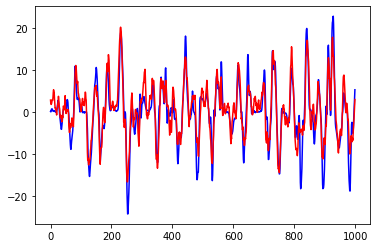

In [85]:
#As an example, I plot an example 1000 values of the x velocity (column index 2), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[1000:2000,2]+y_kf_train_mean[2],'b')
plt.plot(y_valid_predicted_kf[1000:2000,2]+y_kf_train_mean[2],'r')
#Save figure
# fig_x_kf.savefig('x_velocity_decoding.eps')

In [16]:
#Test set

#Get predictions
y_test_predicted_kf=model_kf.predict(X_kf_test,y_kf_test)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_test,y_test_predicted_kf)
print('R2:',R2_kf[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_test,y_test_predicted_kf)
print('rho2:',rho_kf[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

R2: [0.64903543 0.69482121]
rho2: [0.68524289 0.69753024]


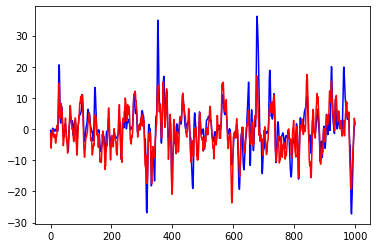

In [17]:
#As an example, I plot an example 1000 values of the x velocity (column index 2), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_test[1000:2000,2]+y_kf_train_mean[2],'b')
plt.plot(y_test_predicted_kf[1000:2000,2]+y_kf_train_mean[2],'r')
#Save figure
# fig_x_kf.savefig('x_velocity_decoding.eps')